In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise

import multiprocessing
from gensim.models import Word2Vec

from nltk.corpus import gutenberg
import nltk
nltk.download('gutenberg')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Importo el corpus con el que se va a trabajar: Moby dick.**

Se definen los documentos como cada oración del corpus.

In [2]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
moby_dick = gutenberg.sents('melville-moby_dick.txt')


In [4]:
display(moby_dick)

[['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', '1851', ']'], ['ETYMOLOGY', '.'], ...]

In [5]:
len(moby_dick)

10059

In [6]:
# Convierto cada sublista (oración) en una cadena de texto
sents_text = [' '.join(sentence) for sentence in moby_dick]

df = pd.DataFrame(sents_text, columns=['Lines'])
df

,Lines
0,[ Moby Dick by Herman Melville 1851 ]
1,ETYMOLOGY .
2,( Supplied by a Late Consumptive Usher to a Gr...
3,"The pale Usher -- threadbare in coat , heart ,..."
4,He was ever dusting his old lexicons and gramm...
...,...
10054,"Till , gaining that vital centre , the black b..."
10055,"Buoyed up by that coffin , for almost one whol..."
10056,"The unharming sharks , they glided by as if wi..."
10057,"On the second day , a sail drew near , nearer ..."


In [7]:
# cuento la cantidad de términos por documento
df['Word Count'] = df['Lines'].apply(lambda x: len(x.split()))
df['Word Count'].describe()

,Word Count
count,10059.000000
mean,25.932896
std,23.915727
min,1.000000
25%,9.000000
50%,20.000000
75%,36.000000
max,542.000000


In [8]:
df

,Lines,Word Count
0,[ Moby Dick by Herman Melville 1851 ],8
1,ETYMOLOGY .,2
2,( Supplied by a Late Consumptive Usher to a Gr...,12
3,"The pale Usher -- threadbare in coat , heart ,...",20
4,He was ever dusting his old lexicons and gramm...,31
...,...,...
10054,"Till , gaining that vital centre , the black b...",57
10055,"Buoyed up by that coffin , for almost one whol...",23
10056,"The unharming sharks , they glided by as if wi...",25
10057,"On the second day , a sail drew near , nearer ...",19


In [9]:
df[df['Word Count']==542]['Lines'].item()

'Though in many natural objects , whiteness refiningly enhances beauty , as if imparting some special virtue of its own , as in marbles , japonicas , and pearls ; and though various nations have in some way recognised a certain royal preeminence in this hue ; even the barbaric , grand old kings of Pegu placing the title " Lord of the White Elephants " above all their other magniloquent ascriptions of dominion ; and the modern kings of Siam unfurling the same snow - white quadruped in the royal standard ; and the Hanoverian flag bearing the one figure of a snow - white charger ; and the great Austrian Empire , Caesarian , heir to overlording Rome , having for the imperial colour the same imperial hue ; and though this pre - eminence in it applies to the human race itself , giving the white man ideal mastership over every dusky tribe ; and though , besides , all this , whiteness has been even made significant of gladness , for among the Romans a white stone marked a joyful day ; and thou

**Creo los tokens de los documentos**

In [10]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Transforma los documentos en tokens
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

<ipython-input-10-39e9bdf37753>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentence_tokens.append(text_to_word_sequence(row[0]))


In [11]:
# reviso el documento 1000
df.iloc[1000,0]

'But he swiftly calls away the Captain from that scent .'

In [12]:
# al pasar a token se pasan los terminos a minúscula y se quitan los signos de puntuación
sentence_tokens[1000]

['but',
 'he',
 'swiftly',
 'calls',
 'away',
 'the',
 'captain',
 'from',
 'that',
 'scent']

**Creo los vectores (word2vec)**

In [13]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [14]:
# Modelo Word2Vec para entrenar los embeddings
w2v_model = Word2Vec(min_count=10,           # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=3,              # cant de palabras antes y desp de la predicha
                     vector_size=100,        # dimensionalidad de los vectores
                     negative=20,           # cantidad de negative samples... 0 es no se usa
                     workers=1,             # si tienen más cores pueden cambiar este valor
                     sg=1)                  # modelo 0:CBOW  1:skipgram

In [15]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [16]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 10059


In [17]:
# Cantidad de words encontradas en el corpus (vocabulario)
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 2182


**Entreno los embeddings**

In [18]:
# Entrenamos el modelo
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 1850854.0
Loss after epoch 1: 1400180.75
Loss after epoch 2: 1333825.25
Loss after epoch 3: 1270523.5
Loss after epoch 4: 1268850.5
Loss after epoch 5: 1260306.5
Loss after epoch 6: 1220263.5
Loss after epoch 7: 1215999.0
Loss after epoch 8: 1208010.0
Loss after epoch 9: 1204279.0
Loss after epoch 10: 1196057.0
Loss after epoch 11: 1190996.0
Loss after epoch 12: 1183495.0
Loss after epoch 13: 1162316.0
Loss after epoch 14: 1155714.0
Loss after epoch 15: 1156758.0
Loss after epoch 16: 1153658.0
Loss after epoch 17: 1155272.0
Loss after epoch 18: 1151618.0
Loss after epoch 19: 1150954.0


(2548614, 4430820)

**Visualizo en 2D y 3D los vectores**

In [19]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [20]:
# Grafico los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab")

In [21]:
# Grafico los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab")

**Reviso las palabras que más se relacionan**

In [22]:
# palabras similares a sea
w2v_model.wv.most_similar(positive=["sea"], topn=10)

[('seas', 0.5173842906951904),
 ('east', 0.5150328874588013),
 ('waves', 0.5071187019348145),
 ('deep', 0.5063601732254028),
 ('gently', 0.49953919649124146),
 ('japan', 0.4967133402824402),
 ('direful', 0.4952948987483978),
 ('gloom', 0.49054834246635437),
 ('mild', 0.48889032006263733),
 ('eternal', 0.48806139826774597)]

Dentro de los términos más similares a 'sea' se encuentran palabras afines como 'seas','waves' y otras palabras que se encuentran cercanas en el texto como los adjetivos 'deep','gently'.

In [23]:
# palabras similares a captain
w2v_model.wv.most_similar(positive=["captain"], topn=10)

[('moody', 0.6033666133880615),
 ('peleg', 0.5972371697425842),
 ('officers', 0.5786779522895813),
 ('bunger', 0.5492300391197205),
 ('guernsey', 0.5191786885261536),
 ('bildad', 0.5177071690559387),
 ('entitled', 0.5148871541023254),
 ('crazy', 0.5133281946182251),
 ('pirates', 0.5103671550750732),
 ('gabriel', 0.5001288056373596)]

Dentro de los términos más similares a 'captain' se encuentran las siguientes relaciones: personajes que interactúan con 'captain' (Peleg), adjetivos que podrían describir al termino orginal ('crazy','moody').

**Realizo un test de analogía**

In [24]:
# Armamos una función para graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words,
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

In [25]:
#defino los términos para hacer el test de analogía
test_words = ['ahab', 'captain', 'moby', 'whale']

# guardo los vectores de embedding de cada término
test_emb = []
for word in test_words:
    test_emb.append(w2v_model.wv.get_vector(word))

test_emb

[array([-0.55664355,  0.5101493 , -0.23039569, -0.2863757 , -0.03368931,
        -0.8833513 , -0.07120524,  0.24784094, -0.42982098, -0.6968426 ,
         0.55970806, -0.2694288 ,  0.28853044,  0.340807  ,  0.08057203,
         0.44135633,  0.6472549 ,  0.2486604 , -0.1093259 , -0.86056894,
         0.38907593, -0.36370832, -0.19460112, -0.2866007 , -0.41603348,
        -0.64862794, -0.17852528,  0.80634195,  0.41341648,  0.378848  ,
         0.20045534,  0.43512622,  0.5324589 ,  0.49643415,  0.37231007,
        -0.0184677 , -0.01807797, -0.23003565, -0.26902097, -0.31987652,
        -0.1624845 , -0.01510811,  0.20323619,  0.41722062, -0.11617213,
        -0.28886053, -0.354706  ,  0.21804753, -0.02659857,  0.27377778,
         0.22602735, -0.04591743,  0.06947017,  0.21591008,  0.16685002,
         0.298058  , -0.24423254, -0.22411536, -0.18028766, -0.00150895,
         0.14162995,  0.00610645,  0.31901804, -0.17917188, -0.00136917,
         0.3301794 , -0.08069116,  0.47309932, -0.0

In [26]:
# hago un nuevo vector
# si se cumple el test 'ahab' - 'captain' + 'whale' debería ser similar a 'moby'
new_word = test_emb[0] - test_emb[1] + test_emb[3]
new_word

array([-0.96863574,  0.5281863 ,  0.10844633,  0.16350359, -0.3588716 ,
       -0.57964087,  0.13702467,  0.38659763, -0.50656646, -1.011214  ,
        0.4755447 , -0.19366243,  0.48019508,  0.3164949 ,  0.7963866 ,
        1.1576525 ,  0.2897508 ,  0.95048535,  0.363652  , -0.09105468,
        0.542532  , -0.24570996, -0.08624391,  0.26135212,  0.17808458,
       -0.23562351, -0.19999753,  0.6803578 ,  0.53757566,  0.60249156,
        0.10204959,  0.12727717,  0.70305973,  0.44479543,  0.6616573 ,
       -0.32300445,  0.4838006 , -0.27662316, -0.3267462 ,  0.12974796,
       -0.25132152, -0.43022335, -0.13261724, -0.17551142, -0.15027234,
        0.11371572, -0.11317147,  0.19223359, -0.9761634 ,  0.30242807,
        0.7005687 , -0.30474207, -0.9019325 , -0.39182645,  0.7982837 ,
        0.29128787, -0.2258531 , -0.22237773,  0.36741477, -0.29320368,
       -0.5423306 , -0.20178752,  0.26838335, -0.22346756,  0.6519642 ,
        0.66786295,  0.43320036,  0.3879165 , -0.4054257 ,  0.63

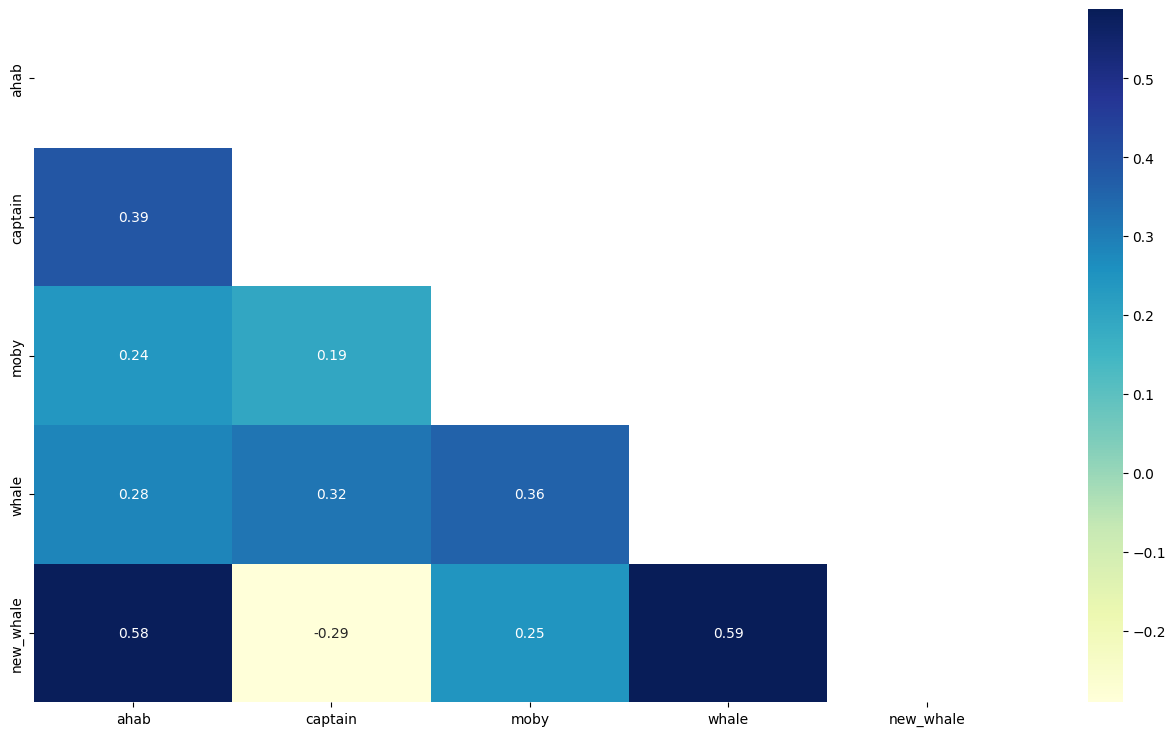

In [27]:
# agrego el nuevo término y calculo la similaridad coseno
new_words = test_words + ['new_whale']

new_emb = np.append(test_emb, new_word.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

Para evaluar la calidad de los embeddings entrenados, se plantea un test de analogías que busca validar la siguiente relación: "Ahab es a captain lo que Moby es a whale".

Al analizar los resultados de la similitud de los vectores, se observa que excluyendo a 'Ahab', por ser el primer término en el cálculo del nuevo vector, los términos con mayor similitud son 'whale' y 'Moby'.

Esto sugiere que el modelo ha capturado adecuadamente las relaciones semánticas en el texto.

In [28]:
#Reviso las palabras más similares a la nueva creada para realizar el test de analogía y veo que dentro de las primeras se encuentra 'whale' y 'ahab'
w2v_model.wv.most_similar(new_word)

[('whale', 0.5876461863517761),
 ('ahab', 0.5824490785598755),
 ('beneath', 0.4300469756126404),
 ('horizontal', 0.42681002616882324),
 ('sperm', 0.4224664866924286),
 ('mystic', 0.4104028642177582),
 ('uncommon', 0.40301015973091125),
 ('elephant', 0.40240854024887085),
 ('motion', 0.3978797495365143),
 ('hump', 0.39650291204452515)]